In [1]:
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import time


In [2]:
import requests

response = requests.get("https://www.gutenberg.org/cache/epub/64317/pg64317.txt")

In [3]:
book_complete_text = response.text
book_complete_text = book_complete_text[5:]
len(book_complete_text)

296884

In [4]:
file_path = "./book.txt"

with open(file_path, "w", encoding="utf-8") as f:
    f.write(book_complete_text)

In [5]:
with open(file_path, "r",  encoding="utf-8") as f:
    text = f.read()

text = text.replace('\t', ' ')

In [6]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=5000, chunk_overlap=300)


In [7]:
documents = text_splitter.create_documents([text])
num_documents = len(documents)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 64 documents


In [8]:
len(documents)

64

In [9]:
chroma_path = "./chroma"
#delete collection if this exists

In [10]:

#embeddings = OllamaEmbeddings(model="mistral:7b", num_gpu=1, show_progress=True)

In [11]:
embeddings2 = OllamaEmbeddings(model="qwen:0.5b-text",  show_progress=True)

In [12]:
import datetime

In [13]:
datetime.datetime.now()

datetime.datetime(2024, 3, 12, 10, 44, 8, 495870)

In [23]:
time1 = datetime.datetime.now()
embeddings2 = OllamaEmbeddings(model="qwen:0.5b-text",  show_progress=True)
emb2 = embeddings2.embed_documents(texts=documents)
time2 = datetime.datetime.now()

OllamaEmbeddings: 100%|████████████████████████████████████████████████████████████████| 64/64 [01:02<00:00,  1.02it/s]


In [24]:
(time2-time1).seconds

62

In [25]:
len(emb2[0])

1024

In [26]:
emb2[0]

[4.015005111694336,
 -2.522308826446533,
 -5.9774627685546875,
 6.868106842041016,
 0.9306864142417908,
 3.3611369132995605,
 0.6985016465187073,
 -7.426858901977539,
 0.9322493076324463,
 -5.289237976074219,
 -0.04708738997578621,
 1.5852481126785278,
 -1.8300755023956299,
 0.05771036818623543,
 1.4564764499664307,
 -1.1395725011825562,
 -0.7950473427772522,
 -7.780210018157959,
 0.6208003163337708,
 -0.44480592012405396,
 -6.907276630401611,
 -1.9051491022109985,
 -4.5303053855896,
 -0.11152942478656769,
 -3.2128140926361084,
 2.1937124729156494,
 1.7752089500427246,
 2.4215433597564697,
 2.737365484237671,
 2.2045083045959473,
 -0.4193391501903534,
 -3.761390209197998,
 -3.47165584564209,
 -5.277930736541748,
 -1.096278190612793,
 1.9903961420059204,
 -0.3642786145210266,
 -6.2451677322387695,
 1.1867412328720093,
 4.414622783660889,
 -6.9432854652404785,
 -4.240804672241211,
 8.855264663696289,
 6.3396782875061035,
 3.4288241863250732,
 6.924649715423584,
 -4.564548492431641,
 1.20

In [76]:
from sklearn.cluster import KMeans
import numpy as np

In [77]:
n_clusters = 8

In [78]:
### Mistral 7B

In [79]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(emb2)

In [80]:
kmeans.labels_

array([3, 0, 4, 0, 0, 6, 6, 7, 0, 1, 0, 4, 0, 0, 0, 7, 4, 0, 1, 5, 0, 7,
       7, 0, 3, 0, 0, 6, 3, 6, 0, 7, 6, 6, 0, 3, 0, 7, 0, 0, 0, 2, 7, 6,
       7, 0, 0, 7, 3, 1, 4, 7, 6, 0, 4, 7, 5, 0, 0, 7, 0, 6, 0, 0])

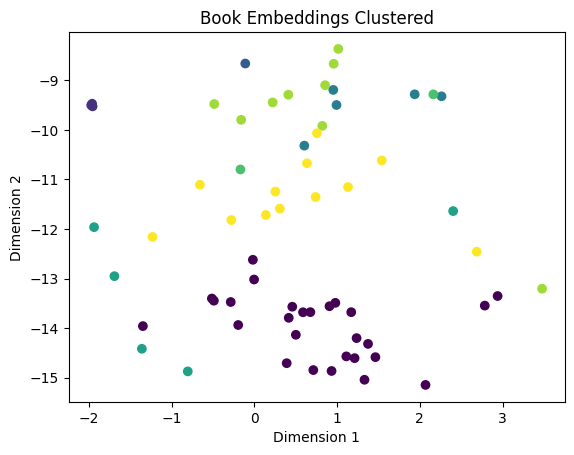

In [81]:
# t-SNE (t-distributed Stochastic Neighbor Embedding) 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(emb2))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [82]:
closest_indices = []

# Loop through the number of clusters you have
for i in range(n_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(emb2 - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

selected_indices = sorted(closest_indices)

selected_docs = [documents[doc] for doc in selected_indices]



In [83]:
selected_indices

[9, 11, 15, 19, 23, 32, 41, 48]

In [30]:
from langchain_community.llms import Ollama
llm = Ollama(model="qwen:0.5b-text")

In [31]:
final_text = documents[9].page_content.replace("\n", " ")

In [32]:
prompt = f"""Summarize this text in 50 words 
{final_text}"""

In [33]:
len(prompt)

5000

In [34]:
time1 = datetime.datetime.now()
response = llm.invoke(prompt)
time2 = datetime.datetime.now()

In [37]:
(time2-time1).seconds

52

In [36]:
len(response)

3724

In [40]:
time1 = datetime.datetime.now()
final_text=""
for x in selected_indices:
    txt = documents[x].page_content.replace("\n", " ")
    prompt = f"""Summarize this text in 50 words 
{txt}"""
    response = llm.invoke(prompt)
    final_text= final_text + " " + response


time2 = datetime.datetime.now()

In [41]:
len(final_text)

36289

In [43]:
(time2-time1).seconds / 60

21.15

In [34]:

llm = Ollama(model="qwen:0.5b-text")


In [35]:
prompt = f"""Summarize this text in 50 words 
{final_text}"""

In [ ]:
time1 = datetime.datetime.now()
response = llm.invoke(prompt)
time2 = datetime.datetime.now()

In [ ]:
(time2-time1).seconds

In [49]:
### Orca Mini3B

In [48]:
kmeans2 = KMeans(n_clusters=n_clusters, random_state=42).fit(emb2)

In [50]:
closest_indices2 = []

# Loop through the number of clusters you have
for i in range(n_clusters):

    # Get the list of distances from that particular cluster center
    distances2 = np.linalg.norm(emb2 - kmeans2.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index2 = np.argmin(distances2)

    # Append that position to your closest indices list
    closest_indices2.append(closest_index2)

selected_indices2 = sorted(closest_indices2)

selected_docs2 = [documents[doc] for doc in selected_indices2]

In [51]:
selected_indices2

[0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
db  = Chroma.from_documents(documents=documents,
                                 embedding=embeddings,
                                 collection_metadata = {"hnsw:space": "cosine"},
                                 persist_directory=chroma_path)


OllamaEmbeddings: 100%|████████████████████████████████████████████████████████████████| 64/64 [25:24<00:00, 23.82s/it]


In [18]:
query = """Lufthansa flies back to profit

German airline Lufthansa has returned to profit in 2004 after posting huge losses in 2003.

In a preliminary report, the airline announced net profits of 400m euros ($527.61m; £274.73m), compared with a loss of 984m euros in 2003. Operating profits were at 380m euros, ten times more than in 2003. Lufthansa was hit in 2003 by tough competition and a dip in demand following the Iraq war and the killer SARS virus. It was also hit by troubles at its US catering business. Last year, Lufthansa showed signs of recovery even as some European and US airlines were teetering on the brink of bankruptcy. The board of Lufthansa has recommended paying a 2004 dividend of 0.30 euros per share. In 2003, shareholders did not get a dividend. The company said that it will give all the details of its 2004 results on 23 March.
"""
docs_with_score = db.similarity_search_with_score(query, k=5)

OllamaEmbeddings: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


In [19]:
for doc, score in docs_with_score:
    print("-" * 80)
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)
    print(f"Class {doc.metadata.get('classifier')}")
    print("-" * 80)

--------------------------------------------------------------------------------
Score:  0.6745374179780821
detail: 1. To start, open the Files app. 2. Next, tap the three-dot menu icon in the top-right. 3. Hit Scan Documents. You can use the Files app to scan physical documents on iOS. Nelson Aguilar/CNET... In response to the increasing tax-related identity theft problem, the Internal Revenue Service (IRS) is monitoring tax returns for signs of fraudulent activity. The most frequent scam is when thieves use a person's name and Social Security number to file a fraudulent return and steal a tax refund. When the IRS suspects a return is fraudulent, the agency will request identity verification ... Tax Documents: The Complete Guide Published: July 3, 2023 Author: Andrew Gartner Tags: taxes , finance , document , In today's complex financial landscape, tax documents play a crucial role in not only ensuring compliance with tax laws but also providing insights into our overall financial hea

In [20]:
db.embeddings

OllamaEmbeddings(base_url='http://localhost:11434', model='mistral', embed_instruction='passage: ', query_instruction='query: ', mirostat=None, mirostat_eta=None, mirostat_tau=None, num_ctx=None, num_gpu=1, num_thread=None, repeat_last_n=None, repeat_penalty=None, temperature=None, stop=None, tfs_z=None, top_k=None, top_p=None, show_progress=True, model_kwargs=None)

In [22]:
docs_with_score = db.similarity_search_with_relevance_scores(query, k=5)

OllamaEmbeddings: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


In [23]:
for doc, score in docs_with_score:
    print("-" * 80)
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)
    print(f"Class {doc.metadata.get('classifier')}")
    print("-" * 80)

--------------------------------------------------------------------------------
Score:  0.3254625820219179
detail: 1. To start, open the Files app. 2. Next, tap the three-dot menu icon in the top-right. 3. Hit Scan Documents. You can use the Files app to scan physical documents on iOS. Nelson Aguilar/CNET... In response to the increasing tax-related identity theft problem, the Internal Revenue Service (IRS) is monitoring tax returns for signs of fraudulent activity. The most frequent scam is when thieves use a person's name and Social Security number to file a fraudulent return and steal a tax refund. When the IRS suspects a return is fraudulent, the agency will request identity verification ... Tax Documents: The Complete Guide Published: July 3, 2023 Author: Andrew Gartner Tags: taxes , finance , document , In today's complex financial landscape, tax documents play a crucial role in not only ensuring compliance with tax laws but also providing insights into our overall financial hea